# Lista 06 - Classificação Binária

>Yanna Torres Gonçalves
>
>Matrícula: 587299
>
>Mestrado em Ciências da Computação


## Parte 01: limpeza e pré-processamento dos dados

In [1]:
# !pip install faiss-gpu-cu12
# !pip install scikit-learn fuzzywuzzy python-Levenshtein spacy nltk sentence_transformers emoji unidecode

In [2]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 34.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
import pandas as pd
import numpy as np
import re

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
import spacy
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
tqdm.pandas()

### a) Ler o dataset fakeTelegram.BR_2022.csv

Utilizamos o mesmo dataset da lista 01, acessando pelo mesmo link.

[https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv](https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv)
   

In [5]:
data_url = "https://media.githubusercontent.com/media/yanna-torres/CKP9011-ciencia-de-dados/refs/heads/lista-01/data/fakeTelegram.BR_2022.csv"

df = pd.read_csv(data_url)

In [6]:
df.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,557586.0,444157.000000,167238.000000,5.575860e+05
mean,5.0,0.017330,0.312245,4.450617e+05
std,0.0,0.464165,0.293699,4.860211e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078454,2.127500e+04
50%,5.0,0.000000,0.197577,1.210935e+05
75%,5.0,0.318200,0.490351,9.726045e+05
max,5.0,0.999200,1.000000,1.516436e+06


### b) Remova os trava-zaps, as linhas repetidas e textos com menos de 5 palavras

#### Removendo os trava-zaps

In [7]:
def has_trava_zap(message):
    if not isinstance(message, str):
        return False  # Garante que só analisa strings

    # Regra 1: muito longo
    if len(message) > 10000:
        return True

    # Regra 2: caracteres invisíveis
    invisible = ''.join(chr(c) for c in range(0x200B, 0x200F + 1)) + '\uFEFF'
    if sum(message.count(c) for c in invisible) > 100:
        return True

    # Regra 3: emojis repetidos
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                              "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    emojis = emoji_pattern.findall(message)
    if any(len(e) > 20 for e in emojis):
        return True

    # Regra 4: baixa diversidade
    unique = set(message)
    if len(unique) < 10 and len(message) > 500:
        return True

    return False

In [8]:
df['trava_zap'] = df['text_content_anonymous'].apply(has_trava_zap)

In [9]:
df_clean = df[df['trava_zap'] == False]

In [10]:
df_clean.drop(columns=['trava_zap'], inplace=True)

/tmp/ipykernel_2354/1420576694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['trava_zap'], inplace=True)


In [11]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,556305.0,442876.000000,166416.000000,5.563050e+05
mean,5.0,0.017676,0.311496,4.448514e+05
std,0.0,0.463547,0.293146,4.859544e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078334,2.125100e+04
50%,5.0,0.000000,0.196892,1.208690e+05
75%,5.0,0.318200,0.488192,9.724220e+05
max,5.0,0.999200,1.000000,1.516436e+06


#### Removendo as linhas repetidas

In [12]:
df_clean = df_clean.drop_duplicates()

In [13]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,556305.0,442876.000000,166416.000000,5.563050e+05
mean,5.0,0.017676,0.311496,4.448514e+05
std,0.0,0.463547,0.293146,4.859544e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078334,2.125100e+04
50%,5.0,0.000000,0.196892,1.208690e+05
75%,5.0,0.318200,0.488192,9.724220e+05
max,5.0,0.999200,1.000000,1.516436e+06


#### Removendo textos com menos de 5 palavras

In [14]:
df_clean = df_clean[df_clean['text_content_anonymous'].str.split().str.len() >= 5]

In [15]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,338045.0,337998.000000,166402.000000,3.380450e+05
mean,5.0,0.022497,0.311514,4.214875e+05
std,0.0,0.529214,0.293150,4.842346e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.381800,0.078340,1.988800e+04
50%,5.0,0.000000,0.196925,8.473500e+04
75%,5.0,0.505300,0.488286,9.726970e+05
max,5.0,0.999200,1.000000,1.516436e+06


### c) Agrupe as linhas com postagens iguais ou semelhantes

In [16]:
df_clean.columns

Index(['date_message', 'id_member_anonymous', 'id_group_anonymous', 'media',
       'media_type', 'media_url', 'has_media', 'has_media_url',
       'text_content_anonymous', 'dataset_info_id', 'date_system',
       'score_sentiment', 'score_misinformation', 'id_message', 'message_type',
       'messenger', 'media_name', 'media_md5'],
      dtype='object')

In [17]:
import emoji
import unidecode

def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = emoji.replace_emoji(text, " ")
    text = re.sub(r"[^\w\sÀ-ÿ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [18]:
df_clean['text_normalized'] = df_clean['text_content_anonymous'].progress_apply(normalize_text)

100%|██████████| 338045/338045 [00:59<00:00, 5673.81it/s]


In [19]:
df_clean = df_clean[df_clean['text_normalized'].notnull()]
df_clean = df_clean[df_clean['text_normalized'] != ""]

In [20]:
len(df_clean)

338034

In [21]:
df_clean = df_clean[df_clean['text_normalized'].str.split().str.len() >= 5]

In [22]:
len(df_clean)

334780

In [23]:
# Remove exact duplicates and count occurrences as "shares"
df_grouped = (
    df_clean.groupby('text_normalized', as_index=False)
      .agg({
            'date_message': 'min',
            'id_member_anonymous': 'first',
            **{col: 'first' for col in df_clean.columns if col != 'text_normalized' and col != 'date_message'}
      })
)

In [24]:
share_counts = df_clean['text_content_anonymous'].value_counts().to_dict()
df_grouped['shares'] = df_grouped['text_content_anonymous'].map(share_counts)

In [25]:
len(df_grouped)

213677

In [26]:
df_grouped.head(5)

,text_normalized,date_message,id_member_anonymous,id_group_anonymous,media,media_type,media_url,has_media,has_media_url,text_content_anonymous,dataset_info_id,date_system,score_sentiment,score_misinformation,id_message,message_type,messenger,media_name,media_md5,shares
0,0 31 dos votos contados,2022-10-02 20:25:52,None,ca8d6cc94923d0967c15917812bb71bb,5db8d948c7921ad7ea5db4d54b1551f5.jpg,image/jpg,None,True,False,"🗳📃 — 0,31% dos votos contados",5,2022-10-03 05:10:41.408186,0.0000,NaN,12118,Imagem,telegram,None,5db8d948c7921ad7ea5db4d54b1551f5,1
1,0 48 dos votos contados,2022-10-02 20:27:10,None,ca8d6cc94923d0967c15917812bb71bb,b5911be07ab3e1d22ec41c9d4c3c02d2.jpg,image/jpg,None,True,False,"📃 — 0,48% dos votos contados",5,2022-10-03 05:10:43.398983,0.0000,NaN,12120,Imagem,telegram,None,b5911be07ab3e1d22ec41c9d4c3c02d2,1
2,0 75 em alta o payroll de setembro 263 mil vei...,2022-10-07 12:51:35,None,2ff252ad4422e11a6a8abfaa747abb55,None,None,t.me/alexeconomia,False,True,"0,75 EM ALTA - O payroll de setembro (263 mil)...",5,2022-10-07 12:51:46.727848,-0.3753,0.005815,49312,Texto,telegram,None,None,1
3,0 800 n a n a alaia azzedine paris france 011 ...,2022-10-02 02:53:42,None,6e4192de8ce3464c5263b0a937e53529,None,None,None,False,False,",,""0 800"",""N/A"",""N/A"",\n\n""Alaia, Azzedine"",""P...",5,2022-10-03 04:54:51.879906,0.0000,0.003349,19900,Texto,telegram,None,None,1
4,0 a 10 vai ter 2o turno o que vocês acham,2022-10-03 00:11:39,None,b11f2df64ac19aad47a50accf32052d6,None,None,None,False,False,"0 a 10 vai ter 2o turno, o que vocês acham ?",5,2022-10-03 05:18:48.986706,0.0000,NaN,154118,Texto,telegram,None,None,1


In [27]:
from sentence_transformers import SentenceTransformer
import torch

# Load a multilingual model (Portuguese-friendly) and move to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)

2025-06-20 22:42:20.254453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750459340.273280    2354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750459340.277770    2354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750459340.290434    2354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750459340.290447    2354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750459340.290450    2354 computation_placer.cc:177] computation placer alr

cuda


In [28]:
# Get embeddings (batch-processed on GPU)
texts = df_grouped['text_normalized'].tolist()
print("Encoding texts into embeddings...")
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, device=device)
df_grouped['embedding'] = embeddings.tolist()

Encoding texts into embeddings...


Batches:   0%|          | 0/3339 [00:00<?, ?it/s]

In [29]:
df_grouped = df_grouped.reset_index(drop=True)
embeddings_array = np.array(df_grouped['embedding'].tolist())

In [30]:
import faiss

faiss.normalize_L2(embeddings)
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings)

In [32]:
from collections import defaultdict

similarity_threshold = 0.9
k = 1000

clusters = defaultdict(list)
removed_indices = set()

for i in tqdm(range(len(df_grouped))):
    if i in removed_indices:
        continue
    vec = embeddings[i].reshape(1, -1)
    D, I = index.search(vec, k)
    for sim, j in zip(D[0][1:], I[0][1:]):
        if j == -1 or j == i or j in removed_indices:
            continue
        if sim >= similarity_threshold:
            clusters[i].append(j)
            removed_indices.add(j)

100%|██████████| 213677/213677 [2:06:24<00:00, 28.17it/s]  


In [33]:
results = []
used = set()

for base_idx, sim_indices in tqdm(clusters.items()):
    if base_idx in used:
        continue
    total_count = df_grouped.iloc[base_idx]['shares']
    used.add(base_idx)
    for sim_idx in sim_indices:
        total_count += df_grouped.iloc[sim_idx]['shares']
        used.add(sim_idx)
    row = df_grouped.iloc[base_idx].copy()
    row['shares'] = total_count
    results.append(row)

# Add remaining unmatched
remaining = df_grouped.loc[~df_grouped.index.isin(used)].copy()
final_df = pd.concat([pd.DataFrame(results), remaining], ignore_index=True)

100%|██████████| 10353/10353 [00:04<00:00, 2570.24it/s]


In [34]:
len(final_df)

178404

In [35]:
final_df.head()

,text_normalized,date_message,id_member_anonymous,id_group_anonymous,media,media_type,media_url,has_media,has_media_url,text_content_anonymous,...,date_system,score_sentiment,score_misinformation,id_message,message_type,messenger,media_name,media_md5,shares,embedding
0,0 31 dos votos contados,2022-10-02 20:25:52,None,ca8d6cc94923d0967c15917812bb71bb,5db8d948c7921ad7ea5db4d54b1551f5.jpg,image/jpg,None,True,False,"🗳📃 — 0,31% dos votos contados",...,2022-10-03 05:10:41.408186,0.0,NaN,12118,Imagem,telegram,None,5db8d948c7921ad7ea5db4d54b1551f5,2,"[0.027809733524918556, 0.09836164861917496, -0..."
1,01 11 2022 08 00 ásia pacífico fechado s p asx...,2022-11-01 11:01:54,None,2ff252ad4422e11a6a8abfaa747abb55,None,None,youtube.com/AlexEconomia,False,True,▪️ 01/11/2022 - 08:00 \n\nÁsia-Pacífico (fecha...,...,2022-11-01 11:02:13.43606,0.0,0.065628,52387,Texto,telegram,None,None,106,"[0.045012831687927246, -0.08233073353767395, 0..."
2,02 10 2022 tse governo sp às 18h 59m 00s,2022-10-02 22:05:53,56b8359fd127312651b80b8ed8030085,ef6bcfbd08be365e9b208c22f1d6ad36,a9dff1444485730d391ca9720108cdb7.jpg,image/jpg,None,True,False,*02.10.2022 TSE - Governo-SP às 18h 59m 00s*,...,2022-10-03 05:13:14.67546,0.0,NaN,43651,Imagem,telegram,None,a9dff1444485730d391ca9720108cdb7,12,"[-0.038795433938503265, 0.20785652101039886, 0..."
3,02 10 2022 tse presidente às 18h 55m 31s,2022-10-02 21:59:55,56b8359fd127312651b80b8ed8030085,ef6bcfbd08be365e9b208c22f1d6ad36,b18ed539a09a227d1fa8de9ad82d7214.jpg,image/jpg,None,True,False,02.10.2022 TSE - Presidente - às 18h 55m 31s,...,2022-10-03 05:13:05.88844,0.0,NaN,43650,Imagem,telegram,None,b18ed539a09a227d1fa8de9ad82d7214,15,"[-0.014751886017620564, 0.32362258434295654, 0..."
4,02 10 2022 tse prévia das 17h 44m 10s,2022-10-02 20:53:12,56b8359fd127312651b80b8ed8030085,ef6bcfbd08be365e9b208c22f1d6ad36,31559a0c6a512e4531296377b981c7c3.jpg,image/jpg,None,True,False,02.10.2022 TSE - Prévia das 17h 44m 10s,...,2022-10-03 05:11:20.651301,0.0,NaN,43648,Imagem,telegram,None,31559a0c6a512e4531296377b981c7c3,2,"[-0.08622369170188904, 0.4251839518547058, 0.0..."


In [36]:
final_df.drop(columns=['embedding']).to_csv("grouped_by_similarity.csv")

In [37]:
final_df[['text_content_anonymous', 'shares']].sort_values(by='shares', ascending=False).head(10)

,text_content_anonymous,shares
5088,Grupo a diretoria bloqueado:\n\nEstá comunidad...,17423
2627,Comentarios de Anderson Martinho de 29 años. B...,1607
46,"1, pressione o botão abaixo dentro de 3 Minuto...",1425
9308,"Welcome, 00\n\n🔸 [USER] — professional tool fo...",1282
7095,Olá 1...2...3...5...8...13...21...34...55...89...,1256
7165,🚨Olá SEJA bem vindo(a) 1- ao grupo Especulando...,1090
177931,سکس مردان ازبک با زن انگلیسی با این vpn از سای...,1019
7098,Olá 182 (-) \n\nSeja bem vindo(a) ao grupo DIR...,724
4573,"Feedback de Afonso Rico 27 ​​anos. Brasil, Li...",698
177964,فیلم سوپر با زیرنویس فارسی ببین😍😍\nبا این فیلت...,632


In [38]:
final_df[['text_normalized', 'text_content_anonymous', 'shares']].sort_values(by='shares', ascending=False).head(10)

,text_normalized,text_content_anonymous,shares
5088,grupo a diretoria bloqueado está comunidade fo...,Grupo a diretoria bloqueado:\n\nEstá comunidad...,17423
2627,comentarios de anderson martinho de 29 años br...,Comentarios de Anderson Martinho de 29 años. B...,1607
46,1 pressione o botão abaixo dentro de 3 minutos...,"1, pressione o botão abaixo dentro de 3 Minuto...",1425
9308,welcome 00 user professional tool for managing...,"Welcome, 00\n\n🔸 [USER] — professional tool fo...",1282
7095,olá 1 2 3 5 8 13 21 34 55 89 144 369 2160 user...,Olá 1...2...3...5...8...13...21...34...55...89...,1256
7165,olá seja bem vindo a 1 ao grupo especulando os...,🚨Olá SEJA bem vindo(a) 1- ao grupo Especulando...,1090
177931,سکس مردان ازبک با زن انگلیسی با این vpn از سای...,سکس مردان ازبک با زن انگلیسی با این vpn از سای...,1019
7098,olá 182 seja bem vindo a ao grupo direita rj r...,Olá 182 (-) \n\nSeja bem vindo(a) ao grupo DIR...,724
4573,feedback de afonso rico 27 anos brasil limeira...,"Feedback de Afonso Rico 27 ​​anos. Brasil, Li...",698
177964,فیلم سوپر با زیرنویس فارسی ببین با این فیلترشک...,فیلم سوپر با زیرنویس فارسی ببین😍😍\nبا این فیلت...,632


---

### d) Colunas Auxiliares

Para facilitar a recuperação de dados em alguns casos, vamos criar colunas auxiliares.

In [41]:
import regex

def is_latin_only(text):
    # This keeps only rows that are entirely Latin script (with punctuation, digits, spaces)
    return bool(regex.fullmatch(r'[\p{Latin}\d\s\p{P}\p{S}]+', str(text)))

cleaned_df = final_df[final_df['text_normalized'].apply(is_latin_only)]

In [42]:
len(cleaned_df)

177088

In [43]:
stop_words = set(stopwords.words('portuguese', 'english'))

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text_no_punct = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text_no_punct)
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered)

cleaned_df['text_no_stopwords'] = cleaned_df['text_normalized'].progress_apply(clean_text)

100%|██████████| 177088/177088 [00:23<00:00, 7675.92it/s] 
/tmp/ipykernel_2354/3109209680.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['text_no_stopwords'] = cleaned_df['text_normalized'].progress_apply(clean_text)


In [44]:
cleaned_df['word_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
cleaned_df['character_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x) if pd.notnull(x) else 0)

100%|██████████| 177088/177088 [00:00<00:00, 260568.77it/s]
/tmp/ipykernel_2354/433556474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['word_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
100%|██████████| 177088/177088 [00:00<00:00, 659245.69it/s]
/tmp/ipykernel_2354/433556474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['character_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x) if pd.notnul

In [45]:
def classify_misinformation(score):
    if score >= 0.66:
        return 'Misinformation'
    elif score >= 0.33:
        return 'Neutral'
    else:
        return 'Non-misinformation'

# Criar coluna de categoria
cleaned_df['misinformation_category'] = cleaned_df['score_misinformation'].progress_apply(classify_misinformation)

100%|██████████| 177088/177088 [00:00<00:00, 949318.34it/s]
/tmp/ipykernel_2354/1520527655.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['misinformation_category'] = cleaned_df['score_misinformation'].progress_apply(classify_misinformation)


In [46]:
cleaned_df['sentiment_category'] = cleaned_df['score_sentiment'].progress_apply(lambda x: "Positive" if x >= 0.05 else ("Negative" if x <= -0.05 else "Neutral"))

100%|██████████| 177088/177088 [00:00<00:00, 802037.06it/s]
/tmp/ipykernel_2354/984165960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['sentiment_category'] = cleaned_df['score_sentiment'].progress_apply(lambda x: "Positive" if x >= 0.05 else ("Negative" if x <= -0.05 else "Neutral"))


In [47]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177088 entries, 0 to 178002
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   text_normalized          177088 non-null  object 
 1   date_message             177088 non-null  object 
 2   id_member_anonymous      76005 non-null   object 
 3   id_group_anonymous       177088 non-null  object 
 4   media                    45526 non-null   object 
 5   media_type               45526 non-null   object 
 6   media_url                32749 non-null   object 
 7   has_media                177088 non-null  bool   
 8   has_media_url            177088 non-null  bool   
 9   text_content_anonymous   177088 non-null  object 
 10  dataset_info_id          177088 non-null  int64  
 11  date_system              177088 non-null  object 
 12  score_sentiment          177059 non-null  float64
 13  score_misinformation     82709 non-null   float64
 14  id_messag

In [48]:
cleaned_df.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message,shares,word_count,character_count
count,177088.0,177059.000000,82709.000000,1.770880e+05,177088.000000,177088.000000,177088.000000
mean,5.0,-0.089941,0.324737,4.377736e+05,1.782182,34.870872,196.823675
std,0.0,0.497998,0.273204,4.906852e+05,42.425497,58.383801,337.418370
min,5.0,-1.000000,0.000003,2.000000e+00,1.000000,5.000000,9.000000
25%,5.0,-0.493900,0.106995,2.462975e+04,1.000000,13.000000,73.000000
50%,5.0,0.000000,0.231084,1.110760e+05,1.000000,19.000000,107.000000
75%,5.0,0.273200,0.488672,9.767492e+05,1.000000,33.000000,184.000000
max,5.0,0.999000,1.000000,1.516427e+06,17423.000000,993.000000,4091.000000


In [49]:
cleaned_df.drop(columns=['embedding']).to_csv("grouped_cleaned.csv")

## Parte 02: Modelo Preditivo (Classificador Binário)

Utilizando os dados referente a postagens no Telegram, crie um modelo preditivo
(classificador binário) para classificar uma mensagem em duas classes possíveis: “viral”
(classe positiva) ou “não viral” (classe negativa).

Para rotular as mensagens únicas (agrupadas) nas classes, “viral” e “não viral”,
utilize a seguinte estratégia: Calcule um limiar (threshold).

Por exemplo, mediana do número de compartilhamentos mais dois desvios
padrões. As mensagens com quantidade de compartilhamentos maiores ou iguais ao limiar
definido devem ser rotuladas como “virais”.

As demais mensagens devem ser rotuladas
como “não virais”.

### Pré-processamento

Removendo mensagens com caracteres 

In [50]:
cleaned_df.columns

Index(['text_normalized', 'date_message', 'id_member_anonymous',
       'id_group_anonymous', 'media', 'media_type', 'media_url', 'has_media',
       'has_media_url', 'text_content_anonymous', 'dataset_info_id',
       'date_system', 'score_sentiment', 'score_misinformation', 'id_message',
       'message_type', 'messenger', 'media_name', 'media_md5', 'shares',
       'embedding', 'text_no_stopwords', 'word_count', 'character_count',
       'misinformation_category', 'sentiment_category'],
      dtype='object')

In [51]:
len(cleaned_df)

177088

In [56]:
cleaned_df[["shares", "text_content_anonymous"]].sort_values(by='shares', ascending=False).head(40)

,shares,text_content_anonymous
5088,17423,Grupo a diretoria bloqueado:\n\nEstá comunidad...
2627,1607,Comentarios de Anderson Martinho de 29 años. B...
46,1425,"1, pressione o botão abaixo dentro de 3 Minuto..."
9308,1282,"Welcome, 00\n\n🔸 [USER] — professional tool fo..."
7095,1256,Olá 1...2...3...5...8...13...21...34...55...89...
7165,1090,🚨Olá SEJA bem vindo(a) 1- ao grupo Especulando...
7098,724,Olá 182 (-) \n\nSeja bem vindo(a) ao grupo DIR...
4573,698,"Feedback de Afonso Rico 27 ​​anos. Brasil, Li..."
9333,627,"Welcome, A MARCOLINO Maranata\n\n🔸 [USER] — pr..."
2160,534,"Bom ter você por aqui, 1. 🇧🇷\n\nConsulte as me..."


In [58]:
len(cleaned_df[cleaned_df['text_normalized'].str.split().str.len() < 5])

0

In [79]:
print(len(cleaned_df[cleaned_df['shares'] > 200]))
print("\n")
print(len(cleaned_df[cleaned_df['shares'] <= 200]))

30


177058


In [80]:
print(len(cleaned_df[cleaned_df['shares'] > 100]))
print("\n")
print(len(cleaned_df[cleaned_df['shares'] <= 100]))

76


177012


In [82]:
print(len(cleaned_df[cleaned_df['shares'] > 75]))
print("\n")
print(len(cleaned_df[cleaned_df['shares'] <= 75]))

103


176985


In [83]:
cleaned_df = cleaned_df[cleaned_df['shares'] <= 100]

### Features

In [84]:
limiar = cleaned_df["shares"].median() + 2 * cleaned_df["shares"].std()
cleaned_df["is_viral"] = (cleaned_df["shares"] >= limiar).astype(int)  # 1 = viral, 0 = não viral

In [85]:
cleaned_df[["shares", "text_content_anonymous", "is_viral"]].sort_values(by='shares', ascending=False).head()

,shares,text_content_anonymous,is_viral
4216,100,Estou muito feliz com esta plataforma Fiz um i...,1
148,99,🇧🇷 2º Turno - Compartilhe 🇧🇷\n\nLista atualiza...,1
2669,97,.COMO COMEÇAR\n\n 1. Prepare seus fundos.\n\n...,1
8359,97,Seja bem vindo ao grupo 3rr0 📚 Este grupo é li...,1
2474,96,*CDBr INFORMA:*\n\n*VAMOS MOSTRAR AOS PETRALHA...,1


In [86]:
cleaned_df["date_message"] = pd.to_datetime(cleaned_df["date_message"])
cleaned_df["hour"] = cleaned_df["date_message"].dt.hour
cleaned_df["day_of_week"] = cleaned_df["date_message"].dt.dayofweek

In [136]:
from sklearn.preprocessing import LabelEncoder

for col in ["media_type", "sentiment_category", "misinformation_category"]:
    cleaned_df[col] = cleaned_df[col].fillna("unknown")
    cleaned_df[col] = LabelEncoder().fit_transform(cleaned_df[col])

In [148]:
feature_cols = [
    "word_count", "character_count", "score_sentiment", "score_misinformation",
    "has_media", "sentiment_category", "misinformation_category",
    "hour", "day_of_week"
]

In [159]:
cleaned_null_df = cleaned_df.dropna(subset=feature_cols)

In [161]:
cleaned_null_df.isnull().sum()

text_normalized                0
date_message                   0
id_member_anonymous        47645
id_group_anonymous             0
media                      62237
media_type                     0
media_url                  66633
has_media                      0
has_media_url                  0
text_content_anonymous         0
dataset_info_id                0
date_system                    0
score_sentiment                0
score_misinformation           0
id_message                     0
message_type                   0
messenger                      0
media_name                 82135
media_md5                  62237
shares                         0
embedding                      0
text_no_stopwords              0
word_count                     0
character_count                0
misinformation_category        0
sentiment_category             0
is_viral                       0
hour                           0
day_of_week                    0
dtype: int64

In [163]:
embedding_matrix = np.vstack(cleaned_null_df["embedding"])

In [218]:
X_base = cleaned_null_df[feature_cols].values
X = np.hstack([X_base, embedding_matrix])
y = cleaned_null_df["is_viral"]

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

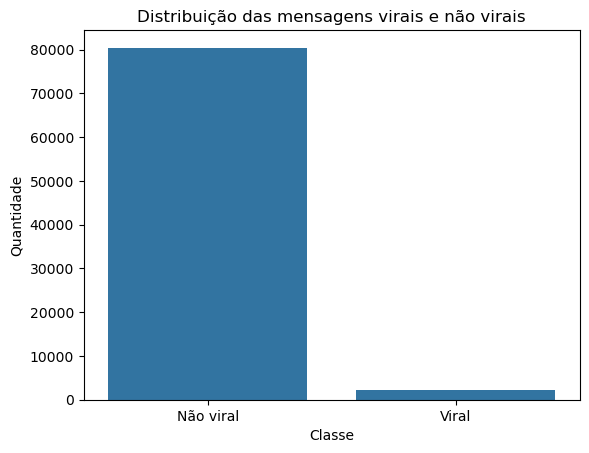

In [165]:
sns.countplot(x="is_viral", data=cleaned_null_df)
plt.title("Distribuição das mensagens virais e não virais")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.xticks([0, 1], ["Não viral", "Viral"])
plt.show()

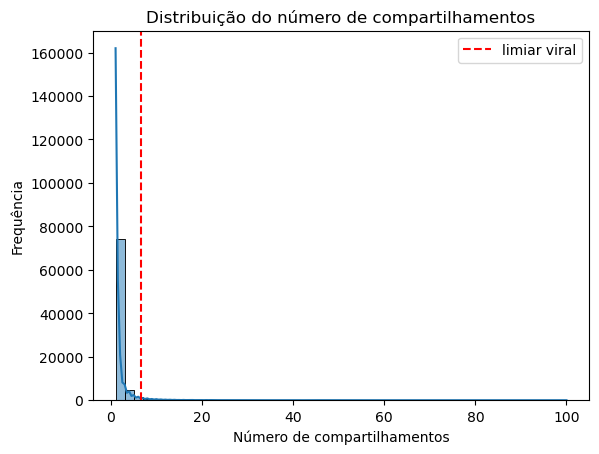

In [166]:
sns.histplot(cleaned_null_df["shares"], bins=50, kde=True)
plt.axvline(limiar, color="red", linestyle="--", label="limiar viral")
plt.title("Distribuição do número de compartilhamentos")
plt.xlabel("Número de compartilhamentos")
plt.ylabel("Frequência")
plt.legend()
plt.show()

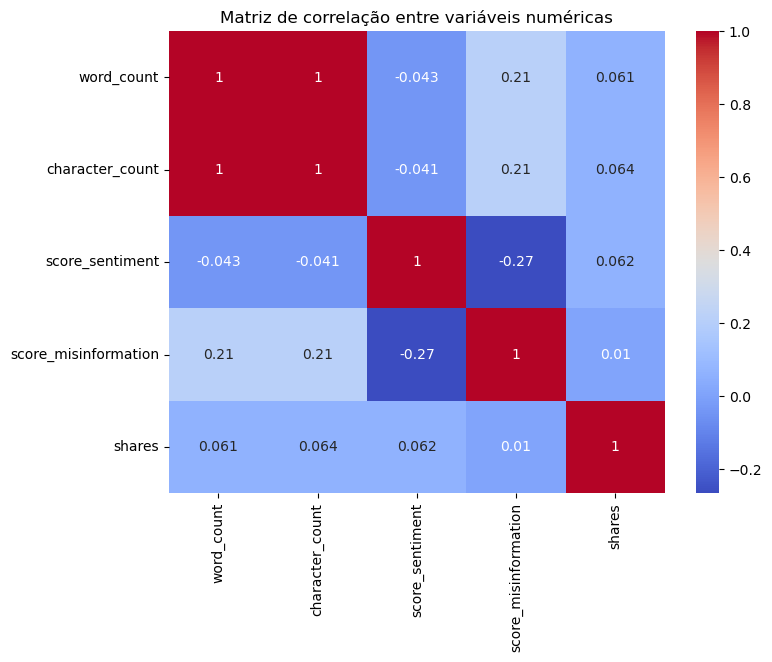

In [167]:
numeric_cols = [
    "word_count", "character_count", "score_sentiment", "score_misinformation", "shares"
]

corr = cleaned_null_df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlação entre variáveis numéricas")
plt.show()

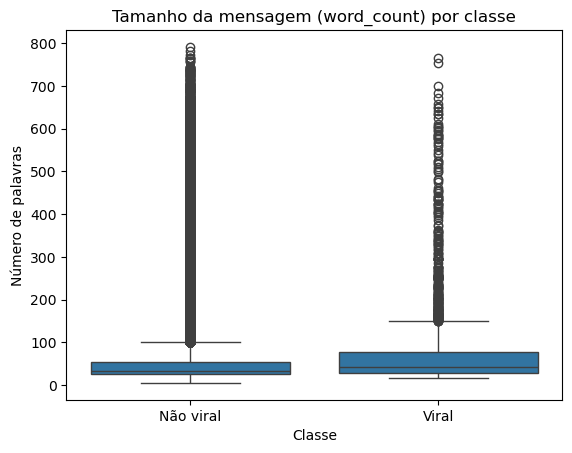

In [168]:
sns.boxplot(x="is_viral", y="word_count", data=cleaned_null_df)
plt.title("Tamanho da mensagem (word_count) por classe")
plt.xlabel("Classe")
plt.ylabel("Número de palavras")
plt.xticks([0, 1], ["Não viral", "Viral"])
plt.show()

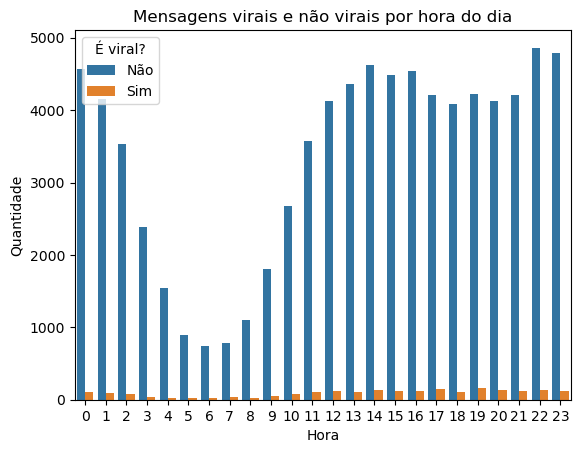

In [169]:
sns.countplot(x="hour", hue="is_viral", data=cleaned_null_df)
plt.title("Mensagens virais e não virais por hora do dia")
plt.xlabel("Hora")
plt.ylabel("Quantidade")
plt.legend(title="É viral?", labels=["Não", "Sim"])
plt.show()

### Training

#### Regressão Logística

In [206]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report, roc_curve, auc, confusion_matrix
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt

def run_logistic_experiment(
    X, y,
    test_size=0.2,
    balance_strategy=None,         # None, "smote", "ros", "rus"
    normalize=None,                # None, "zscore", "minmax"
    penalty="l2",                  # "none", "l1", "l2", "elasticnet"
    solver="liblinear",            # "liblinear", "saga", etc.
    class_weight=None,             # None, "balanced"
    max_iter=1000,
    l1_ratio=None,                 # only for elasticnet
    verbose=True
):
    print(f"\n🔧 Config: balance={balance_strategy}, normalize={normalize}, penalty={penalty}, weight={class_weight}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=42
    )

    # Normalize
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Balance
    if balance_strategy == "smote":
        sampler = SMOTE(random_state=42)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=42)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = None

    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    # Train model
    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=max_iter,
        l1_ratio=l1_ratio,   # ignored if not elasticnet
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    # Print report
    print("\n📊 Classification Report")
    report_dict = classification_report(y_test, y_pred, target_names=["Não viral", "Viral"], output_dict=True)
    print(classification_report(y_test, y_pred, target_names=["Não viral", "Viral"]))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Não viral", "Viral"], yticklabels=["Não viral", "Viral"])
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Plot curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Falso Positivo (FPR)")
    plt.ylabel("Verdadeiro Positivo (TPR)")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot métricas por classe
    df_plot = pd.DataFrame(report_dict).transpose().loc[["Não viral", "Viral"], ["precision", "recall", "f1-score"]]
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Desempenho por Classe")
    plt.show()

    return report_dict

In [213]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def generate_features(
    df,
    text_column="text_normalized",
    feature_cols=None,
    embedding_method="tfidf",  # "bow", "tfidf", "word2vec"
    ngram_range=(1,1),
    w2v_model=None
):
    """
    Gera matriz X com features textuais + estruturadas.

    Parâmetros:
    - df: DataFrame com dados
    - text_column: nome da coluna texto para vetorização
    - feature_cols: lista colunas numéricas estruturadas para concatenar
    - embedding_method: "bow", "tfidf" ou "word2vec"
    - ngram_range: intervalo de n-gramas para vetorizadores (ex: (1,2))
    - w2v_model: modelo gensim Word2Vec (necessário se embedding_method="word2vec")

    Retorna:
    - X: matriz numpy com features concatenadas
    - y: vetor de rótulos (assume coluna "is_viral" no df)
    """
    # Preparar texto
    texts = df[text_column].fillna("").values

    # Extrair features textuais
    if embedding_method == "bow":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=5000)
        X_text = vectorizer.fit_transform(texts)

    elif embedding_method == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=5000)
        X_text = vectorizer.fit_transform(texts)

    elif embedding_method == "word2vec":
        if w2v_model is None:
            raise ValueError("Para Word2Vec é necessário passar o modelo w2v_model treinado")
        X_text = []
        for doc in texts:
            tokens = str(doc).split()
            vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
            if len(vecs) == 0:
                X_text.append(np.zeros(w2v_model.vector_size))
            else:
                X_text.append(np.mean(vecs, axis=0))
        X_text = np.array(X_text)

    else:
        raise ValueError(f"Embedding '{embedding_method}' não suportado.")

    # Features estruturadas
    if feature_cols is not None and len(feature_cols) > 0:
        X_struct = df[feature_cols].values
    else:
        X_struct = None

    # Combinar texto + estruturadas
    if embedding_method in ["bow", "tfidf"]:
        # X_text é esparso
        if X_struct is not None:
            X = np.hstack([X_struct, X_text.toarray()])
        else:
            X = X_text.toarray()
    else:
        # Word2Vec já é denso
        if X_struct is not None:
            X = np.hstack([X_struct, X_text])
        else:
            X = X_text

    # Rótulo
    y = df["is_viral"].values

    return X, y

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer

def build_feature_matrix_with_tfidf(df, text_column, feature_cols, ngram_range=(1,1), max_features=1000):
    """
    Combina TF-IDF da coluna de texto com atributos estruturados.

    Parâmetros:
    - df: DataFrame com os dados
    - text_column: nome da coluna de texto
    - feature_cols: lista de colunas estruturadas
    - ngram_range: (1,1)=unigramas, (1,2)=bigrams, etc.
    - max_features: número máximo de features do TF-IDF

    Retorna:
    - X: matriz final (TF-IDF + atributos)
    - y: vetor de rótulos
    """
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_text = vectorizer.fit_transform(df[text_column].fillna(""))

    X_structured = df[feature_cols].values
    X_combined = np.hstack([X_structured, X_text.toarray()])

    y = df["is_viral"]
    return X_combined, y


##### Experimento 1: Embeddings SentenceTransformer, sem balanceamento, sem normalização e sem regularização

In [ ]:
report_st_none_none_none_saga = run_logistic_experiment(
    X, y,
    balance_strategy=None,
    normalize=None,
    penalty="none",
    solver="saga",
    class_weight=None
)


🔧 Config: balance=None, normalize=None, penalty=none, weight=None


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


##### Experimento 2: Embeddings SentenceTransformer, SMOTE, sem normalização e sem regularização

In [ ]:
report_st_smote_none_none_saga = run_logistic_experiment(
    X, y,
    balance_strategy="smote",
    normalize=None,
    penalty="none",
    class_weight=None
)

In [ ]:
X_tfidf, y_tfidf = generate_features(
    cleaned_null_df,
    embedding_method="tfidf",
    feature_cols=feature_cols,
    ngram_range=(1,2)
)

In [ ]:
report_tfidf_none_none_none_saga = run_logistic_experiment(
    X_tfidf, y_tfidf,
    balance_strategy=None,
    normalize=None,
    penalty="none",
    solver="saga",
    class_weight=None
)


🔧 Config: balance=None, normalize=None, penalty=none, weight=None


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
